In [115]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy.integrate import solve_ivp
from scipy import constants

In [116]:
# Conditions
V0 = 750 # Vmax (V)
f0 = 50000 # RF frequency (Hz)
w0 = 2 * np.pi * f0 # Angular frequency
dgap = 1e-4 # gap length (m)
ddiel = 1e-4 # dielectric thickness (m)
dplate = 0.1 # Plate diameter (m)
As = 0.25 * np.pi * dplate**2 # Plate area (m2)
P = 1 # pressure (atm)
T = 400 # Temperature (K)


In [117]:
# Parameters
epsr = 10 # relative permittivity
eps0 = 8.8541878128e-12 # vacuum permittivity (F/m)
type_EEDF = 1 # 1:Maxwellian EEDF, 2:Druyvesteyn EEDF, 1~2: Generalized EEDF
me = constants.electron_mass # electron mass (kg)
qe = constants.elementary_charge # electron charge (C)
NA = constants.Avogadro # Avogadro number (1/mol)
R = 8.2057366e-5 # gas constant (m3-atm/K/mol)
kb = constants.Boltzmann # Boltzmann constant (J/K)
F = 96485.33289 #Faraday constant (C/mol)
z_Ar1p = 1 # Charge of Ar ion

In [118]:
# Properties
Mw_AR = 40/1000 # kg/mol
sigma_AR = 3.33e-10 # m, Ar potential characteristic length

In [119]:
# Electron Collision Reaction Source Treatment
with open('Ar_xsecs.txt', 'r') as file:
    data = file.read()
    file.close()

In [120]:
# Cross-section area Data Generation
rawD = data.split('\n')
rawD = [x for x in rawD if x != '']

reaction_index = []
for i in range(len(rawD)):
    if rawD[i].startswith('Type'):
        reaction_index.append(i)

R_type = list(range(len(reaction_index)))
R_eqn = list(range(len(reaction_index)))
R_Eloss = list(range(len(reaction_index)))
R_ext = list(range(len(reaction_index)))
R_Elevel = []
R_crossA = []
for i, name in enumerate(reaction_index):
    R_type[i] = rawD[name].split(' ')[1]
    R_eqn[i] = rawD[name+1]
    R_Eloss[i] = float(rawD[name+2].split(' ')[0])
    if R_type[i] == 'EXCITATION':
        R_ext[i] = float(rawD[name+2].split(' ')[2])
    else:
        R_ext[i] = 0
    if i != len(reaction_index) - 1:
        data_range = list(range(reaction_index[i]+5,reaction_index[i+1]-1))
        Elevel = list(range(len(data_range)))
        crossA = list(range(len(data_range)))
        iteration = 0
        for j in data_range:
            Elevel[iteration] = float(rawD[j].split(' ')[2])
            crossA[iteration] = float(rawD[j].split(' ')[4])
            iteration += 1
        R_Elevel.append(np.array(Elevel))
        R_crossA.append(np.array(crossA))
    else:
        data_range = list(range(reaction_index[i]+5,len(rawD)-1))
        Elevel = list(range(len(data_range)))
        crossA = list(range(len(data_range)))
        iteration = 0
        for j in data_range:
            Elevel[iteration] = float(rawD[j].split(' ')[2])
            crossA[iteration] = float(rawD[j].split(' ')[4])
            iteration += 1
        R_Elevel.append(Elevel)
        R_crossA.append(crossA)


In [121]:
# Cross-section area interpolation function
from scipy import interpolate
def create_cross_section_interpolator(Elevel,crossA):
    def non_negative_interp(x):
        return np.maximum(0, interpolate.interp1d(Elevel, crossA, kind='cubic', fill_value='extrapolate')(x))
    return non_negative_interp

R_cross_interpolator = list(range(len(reaction_index)))
for i in range(len(reaction_index)):
    R_cross_interpolator[i] = create_cross_section_interpolator(R_Elevel[i],R_crossA[i])

def calculate_cross_section(interpolator, energy):
    return interpolator(energy)

In [122]:
# upper incomplete gamma function
from scipy import special

def upper_incomplete_gamma(a):
    return special.gamma(a)

# EEDF calculation
def calculate_EEDF(type_EEDF,E,E_mean):
    g = type_EEDF
    beta1 = (upper_incomplete_gamma(5/(2*g)))**(3/2)*(upper_incomplete_gamma(3/(2*g)))**(-5/2)
    beta2 = upper_incomplete_gamma(5/(2*g))*upper_incomplete_gamma(3/(2*g))**(-1)
    return g*beta1*E_mean**(-3/2)*np.exp(-(E*beta2/E_mean)**g)

In [123]:
e_grid = np.arange(0,100,0.01)

In [124]:
# Rate Expression
def Rate_coeff(E_mean):
    R_coeff = list(range(len(R_Elevel)))
    for i in range(len(R_coeff)):
        EEDF = calculate_EEDF(type_EEDF,e_grid, E_mean)
        crossA = calculate_cross_section(R_cross_interpolator[i],e_grid)
        R_coeff[i] = np.sqrt(2 * qe / me) * np.trapz(EEDF * crossA * e_grid,e_grid)*NA
    return R_coeff


In [125]:
# Detailed Balance for de-excitation process
index_excitation = [i for i, name in enumerate(R_type) if name == 'EXCITATION']
for i in index_excitation:
    eloss = R_Eloss[i]
    e = R_Elevel[i] - eloss + 1e-15
    sig = calculate_cross_section(R_cross_interpolator[i],R_Elevel[i])
    R_type.append('DE-EXCITATION')
    R_Elevel.append(e)
    R_crossA.append(1/R_ext[i]*(e+eloss)/e*sig)
    R_Eloss.append(-eloss)
    R_eqn.append(f'(rev){R_eqn[i]}')

iter = list(range(len(reaction_index),len(R_eqn)))

for j in iter:
    R_cross_interpolator.append(create_cross_section_interpolator(R_Elevel[j],R_crossA[j]))

In [126]:
# Gas Phase Reaction
k_gas = []
# Ars + Ars => e + Ar + Ar+
R_type.append('Pooling')
R_eqn.append('Ars+Ars=>e+Ar+Ar1p')
R_Eloss.append(0)
k_gas.append(337340000) # forward rate constant (m3/s/mol)
# Ars + Ars => e + Ar + Ar+
R_type.append('Quenching')
R_eqn.append('Ars+Ar=>Ar+Ar')
R_Eloss.append(0)
k_gas.append(1807) # forward rate constant (m3/mol/s)

In [127]:
def calculate_reaction_rates(R_eqn, k, concentrations):
    reaction_rates = []
    for i, eqn in enumerate(R_eqn):
        # 반응물과 생성물 분리
        reactants, products = eqn.split('=>')
        if 'rev' in reactants:
            reactants = products
        # 반응 속도 계산
        rate = k[i]
        for reactant in reactants.split('+'):
            reactant = reactant.strip()
            if reactant == 'e':
                rate *= concentrations['e']
            elif reactant == 'Ar':
                rate *= concentrations['Ar']
            elif reactant == 'Ars':
                rate *= concentrations['Ars']
            elif reactant == 'Ar1p':
                rate *= concentrations['Ar1p']
        
        reaction_rates.append(rate)
    
    return reaction_rates

In [128]:
# plasma model
def model(t,y):
    n_e, n_Ar, n_Ars, n_Ar1p, en, sigma_s1, sigma_s2 = y

    # electron energy
    E_mean = min(max(en / n_e, 1e-30),8.5)

    # calculate elastic collision energy loss
    R_Eloss[0] = 2*me*NA/Mw_AR*(E_mean - 1.5*T*kb/qe)

    # Component molar concentration
    conc = {
        'e': n_e/NA,
        'Ar': n_Ar/NA,
        'Ars': n_Ars/NA,
        'Ar1p': n_Ar1p/NA
    }
    # reaction rate
    r = calculate_reaction_rates(R_eqn, Rate_coeff(E_mean)+k_gas,conc)

    # Inelastic collision frequency
    nue = 0
    for i in range(5):
        nue += r[i] / (n_e/NA)
    
    # Collisional Power Loss
    Sen = 0
    for i in range(5):
        Sen += -r[i] * R_Eloss[i] * F
    
    #mass balance
    dne_dt = (r[2] + r[3] + r[5]) * NA
    dn_Ar_dt = (-r[1] - r[2] + r[4] + r[5] + r[6])*NA
    dn_Ars_dt = (r[1] - r[3] - r[4] - 2*r[5] - r[6])*NA
    dn_Ar1p_dt = (r[2] + r[3] + r[5])*NA

    # electron mobility
    mu_e = qe / (me*nue + 1e-30) 

    # electron temperature
    Te = max(2*en/(3*n_e),1e-30)

    # Electron Current Density on wall
    nue_th = np.sqrt(8*qe*Te/me/np.pi) #electron thermal velocity (m/s)
    ne_bnd = -0.5*n_e*nue_th # electron density wall boundary condition
    nje = qe * ne_bnd # electron current density on wall (A/m2)

    # calculate the voltage and electric field
    V_applied = -V0 * np.sin(w0 * t)
    A = np.array([[-epsr,1,0],[0,-1,epsr],[1,1,1]])
    B = np.array([sigma_s1*ddiel/eps0,sigma_s2*ddiel/eps0, V_applied])
    dV_d1, dV_gap, dV_d2 = np.linalg.solve(A, B)

    V_d1 = V0 - dV_d1
    V_gap = V_d1 - dV_gap
    V_d2 = V_gap - dV_d2

    E_d1 = dV_d1/ddiel
    E_gap = dV_gap/dgap
    E_d2 = dV_d2/ddiel

    # Ar1p behavior
    C_Ar1p = n_Ar1p / NA
    x_Ar = n_Ar / (n_Ar + n_Ars + n_Ar1p)
    x_Ars = n_Ars / (n_Ar + n_Ars + n_Ar1p)
    w_Ar1p = Mw_AR*n_Ar1p / (Mw_AR*n_Ar + Mw_AR*n_Ars + Mw_AR*n_Ar1p+2.22e-16)
    Dik_Ar1p_Ar = 0.02695*np.sqrt(5e-4*(Mw_AR+Mw_AR)*(T**3)/(Mw_AR*Mw_AR))/(P*101325*(5e9*(sigma_AR+sigma_AR))**2) # kinetic gas theory
    Dik_Ar1p_Ars = 0.02695*np.sqrt(5e-4*(Mw_AR+Mw_AR)*(T**3)/(Mw_AR*Mw_AR))/(P*101325*(5e9*(sigma_AR+sigma_AR))**2) # kinetic gas theory
    Dm_Ar1p = (1-w_Ar1p)/(x_Ar/Dik_Ar1p_Ar+x_Ars/Dik_Ar1p_Ars) # mixture averaged diffusion coefficient m2/s
    um_Ar1p = Dm_Ar1p * qe /kb/T # mobility (m2/V/s)
    
    # Ion Current Density on wall_1
    unx = -1
    ndotE_Ar1p_1 = unx*E_gap
    if z_Ar1p*ndotE_Ar1p_1 > 0:
        migbnd_Ar1p_1 = C_Ar1p*um_Ar1p*z_Ar1p*ndotE_Ar1p_1
    else:
        migbnd_Ar1p_1 = 0

    R1_surf_Ar1p = -migbnd_Ar1p_1
    nji_Ar1p_w1= -F * R1_surf_Ar1p * z_Ar1p/np.sqrt(z_Ar1p**2)

    # Total Ion current density
    njt1 = nji_Ar1p_w1

    # Surface charge density
    dsig1_dt = (-njt1 - nje)
    dsig2_dt = -dsig1_dt
    

    # energy gain from electric field
    mflux = n_e*mu_e*E_gap
    Pcap = qe*mflux*E_gap # Capacitive power deposition

    den_dt = (Pcap + Sen)/qe

    return [dne_dt, dn_Ar_dt, dn_Ars_dt, dn_Ar1p_dt, den_dt, dsig1_dt, dsig2_dt]

In [129]:
# initialization
n_e0 = 1e6
n_Ar0 = P/R/T*0.99999999999*NA
n_Ars0 = P/R/T*(1-0.99999999999)*NA
n_Ar1p0 = n_e0
en0 = 5 * n_e0
sigma_s10 = 0
sigma_s20 = 0


In [133]:
# 시간 그리드
tend= 1e-6
t_span = (0,tend)

# 시뮬레이션 실행
sol = solve_ivp(model, t_span, [n_e0, n_Ar0, n_Ars0, n_Ar1p0, en0, sigma_s10, sigma_s20], method='BDF')



c:\Python\Python312\Lib\site-packages\scipy\integrate\_ivp\common.py:346: RuntimeWarning: overflow encountered in multiply
  h_new = (y[ind] + new_factor * y_scale[ind]) - y[ind]
C:\Users\USER\AppData\Local\Temp\ipykernel_22920\3644960046.py:66: RuntimeWarning: invalid value encountered in scalar divide
  w_Ar1p = Mw_AR*n_Ar1p / (Mw_AR*n_Ar + Mw_AR*n_Ars + Mw_AR*n_Ar1p+2.22e-16)
c:\Python\Python312\Lib\site-packages\scipy\integrate\_ivp\common.py:315: RuntimeWarning: overflow encountered in multiply
  h = (y + factor * y_scale) - y
c:\Python\Python312\Lib\site-packages\scipy\integrate\_ivp\common.py:345: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
c:\Python\Python312\Lib\site-packages\scipy\integrate\_ivp\common.py:367: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


KeyboardInterrupt: 

In [131]:
t_pr = -1
t = sol.t[t_pr]
n_e, n_Ar, n_Ars, n_Ar1p, en, sigma_s1, sigma_s2 = sol.y[0,t_pr], sol.y[1,t_pr], sol.y[2,t_pr], sol.y[3,t_pr], sol.y[4,t_pr], sol.y[5,t_pr], sol.y[6,t_pr]

# electron energy
E_mean = en / n_e

# calculate elastic collision energy loss
R_Eloss[0] = 2*me*NA/Mw_AR*(E_mean - 1.5*T*kb/qe)

# Component molar concentration
conc = {
    'e': n_e/NA,
    'Ar': n_Ar/NA,
    'Ars': n_Ars/NA,
    'Ar1p': n_Ar1p/NA
}
# reaction rate
r = calculate_reaction_rates(R_eqn, Rate_coeff(E_mean)+k_gas,conc)

# Inelastic collision frequency
nue = 0
for i in range(5):
    nue += r[i] / (n_e/NA)

# Collisional Power Loss
Sen = 0
for i in range(5):
    Sen += -r[i] * R_Eloss[i] * F

#mass balance
dne_dt = (r[2] + r[3] + r[5]) * NA
dn_Ar_dt = (-r[1] - r[2] + r[4] + r[5] + r[6])*NA
dn_Ars_dt = (r[1] - r[3] - r[4] - 2*r[5] - r[6])*NA
dn_Ar1p_dt = (r[2] + r[3] + r[5])*NA

# electron mobility
mu_e = qe / (me*nue + 1e-30) 

# electron temperature
Te = max(2*en/(3*n_e),1e-30)

# Electron Current Density on wall
nue_th = np.sqrt(8*qe*Te/me/np.pi) #electron thermal velocity (m/s)
ne_bnd = -0.5*n_e*nue_th # electron density wall boundary condition
nje = qe * ne_bnd # electron current density on wall (A/m2)

# calculate the voltage and electric field
V_applied = -V0 * np.sin(w0 * t)
A = np.array([[-epsr,1,0],[0,-1,epsr],[1,1,1]])
B = np.array([sigma_s1*ddiel/eps0,sigma_s2*ddiel/eps0, V_applied])
dV_d1, dV_gap, dV_d2 = np.linalg.solve(A, B)

V_d1 = V0 - dV_d1
V_gap = V_d1 - dV_gap
V_d2 = V_gap - dV_d2

E_d1 = dV_d1/ddiel
E_gap = dV_gap/dgap
E_d2 = dV_d2/ddiel

# Ar1p behavior
C_Ar1p = n_Ar1p / NA
x_Ar = n_Ar / (n_Ar + n_Ars + n_Ar1p)
x_Ars = n_Ars / (n_Ar + n_Ars + n_Ar1p)
w_Ar1p = Mw_AR*n_Ar1p / (Mw_AR*n_Ar + Mw_AR*n_Ars + Mw_AR*n_Ar1p)
Dik_Ar1p_Ar = 0.02695*np.sqrt(5e-4*(Mw_AR+Mw_AR)*(T**3)/(Mw_AR*Mw_AR))/(P*101325*(5e9*(sigma_AR+sigma_AR))**2) # kinetic gas theory
Dik_Ar1p_Ars = 0.02695*np.sqrt(5e-4*(Mw_AR+Mw_AR)*(T**3)/(Mw_AR*Mw_AR))/(P*101325*(5e9*(sigma_AR+sigma_AR))**2) # kinetic gas theory
Dm_Ar1p = (1-w_Ar1p)/(x_Ar/Dik_Ar1p_Ar+x_Ars/Dik_Ar1p_Ars) # mixture averaged diffusion coefficient m2/s
um_Ar1p = Dm_Ar1p * qe /kb/T # mobility (m2/V/s)

# Ion Current Density on wall_1
unx = -1
ndotE_Ar1p_1 = unx*E_gap
if z_Ar1p*ndotE_Ar1p_1 > 0:
    migbnd_Ar1p_1 = C_Ar1p*um_Ar1p*z_Ar1p*ndotE_Ar1p_1
else:
    migbnd_Ar1p_1 = 0

R1_surf_Ar1p = -migbnd_Ar1p_1
nji_Ar1p_w1= -F * R1_surf_Ar1p * z_Ar1p/np.sqrt(z_Ar1p**2)

# Total Ion current density
njt1 = nji_Ar1p_w1

# Surface charge density
dsig1_dt = (-njt1 - nje)
dsig2_dt = -dsig1_dt


# energy gain from electric field
mflux = n_e*mu_e*E_gap
Pcap = qe*mflux*E_gap # Capacitive power deposition

den_dt = (Pcap + Sen)/qe

print(f'ne: {np.format_float_scientific(n_e,precision=5)}')
print(f'nAr: {np.format_float_scientific(n_Ar,precision=5)}')
print(f'nArs: {np.format_float_scientific(n_Ars,precision=5)}')
print(f'nAr1p: {np.format_float_scientific(n_Ar1p,precision=5)}')
print(f'en: {np.format_float_scientific(en,precision=5)}')
print(f'sigma_s1: {np.format_float_scientific(sigma_s1,precision=5)}')
print(f'sigma_s2: {np.format_float_scientific(sigma_s2,precision=5)}')
print(f'E_mean: {np.format_float_scientific(E_mean,precision=5)}')
print(f'r_1: {np.format_float_scientific(r[0],precision=5)}')
print(f'r_2: {np.format_float_scientific(r[1],precision=5)}')
print(f'r_3: {np.format_float_scientific(r[4],precision=5)}')
print(f'r_4: {np.format_float_scientific(r[2],precision=5)}')
print(f'r_5: {np.format_float_scientific(r[3],precision=5)}')
print(f'r_6: {np.format_float_scientific(r[5],precision=5)}')
print(f'r_7: {np.format_float_scientific(r[6],precision=5)}')
print(f'Sen: {np.format_float_scientific(Sen,precision=5)}')
print(f'Pcap: {np.format_float_scientific(Pcap,precision=5)}')
print(f'nJe: {np.format_float_scientific(nje,precision=5)}')
print(f'nJt: {np.format_float_scientific(njt1,precision=5)}')


ne: 8.33308e+07
nAr: 1.83473e+25
nArs: 1.82467e+14
nAr1p: 8.33308e+07
en: 2.37500e+08
sigma_s1: 7.16586e-14
sigma_s2: -7.16586e-14
E_mean: 2.85009e+00
r_1: 1.20384e-04
r_2: 6.78683e-08
r_3: 2.36328e-17
r_4: 1.53999e-08
r_5: 4.16696e-16
r_6: 3.09694e-11
r_7: 1.66807e-05
Sen: -9.96736e-02
Pcap: 1.03954e-01
nJe: -6.15815e-06
nJt: 2.30704e-09


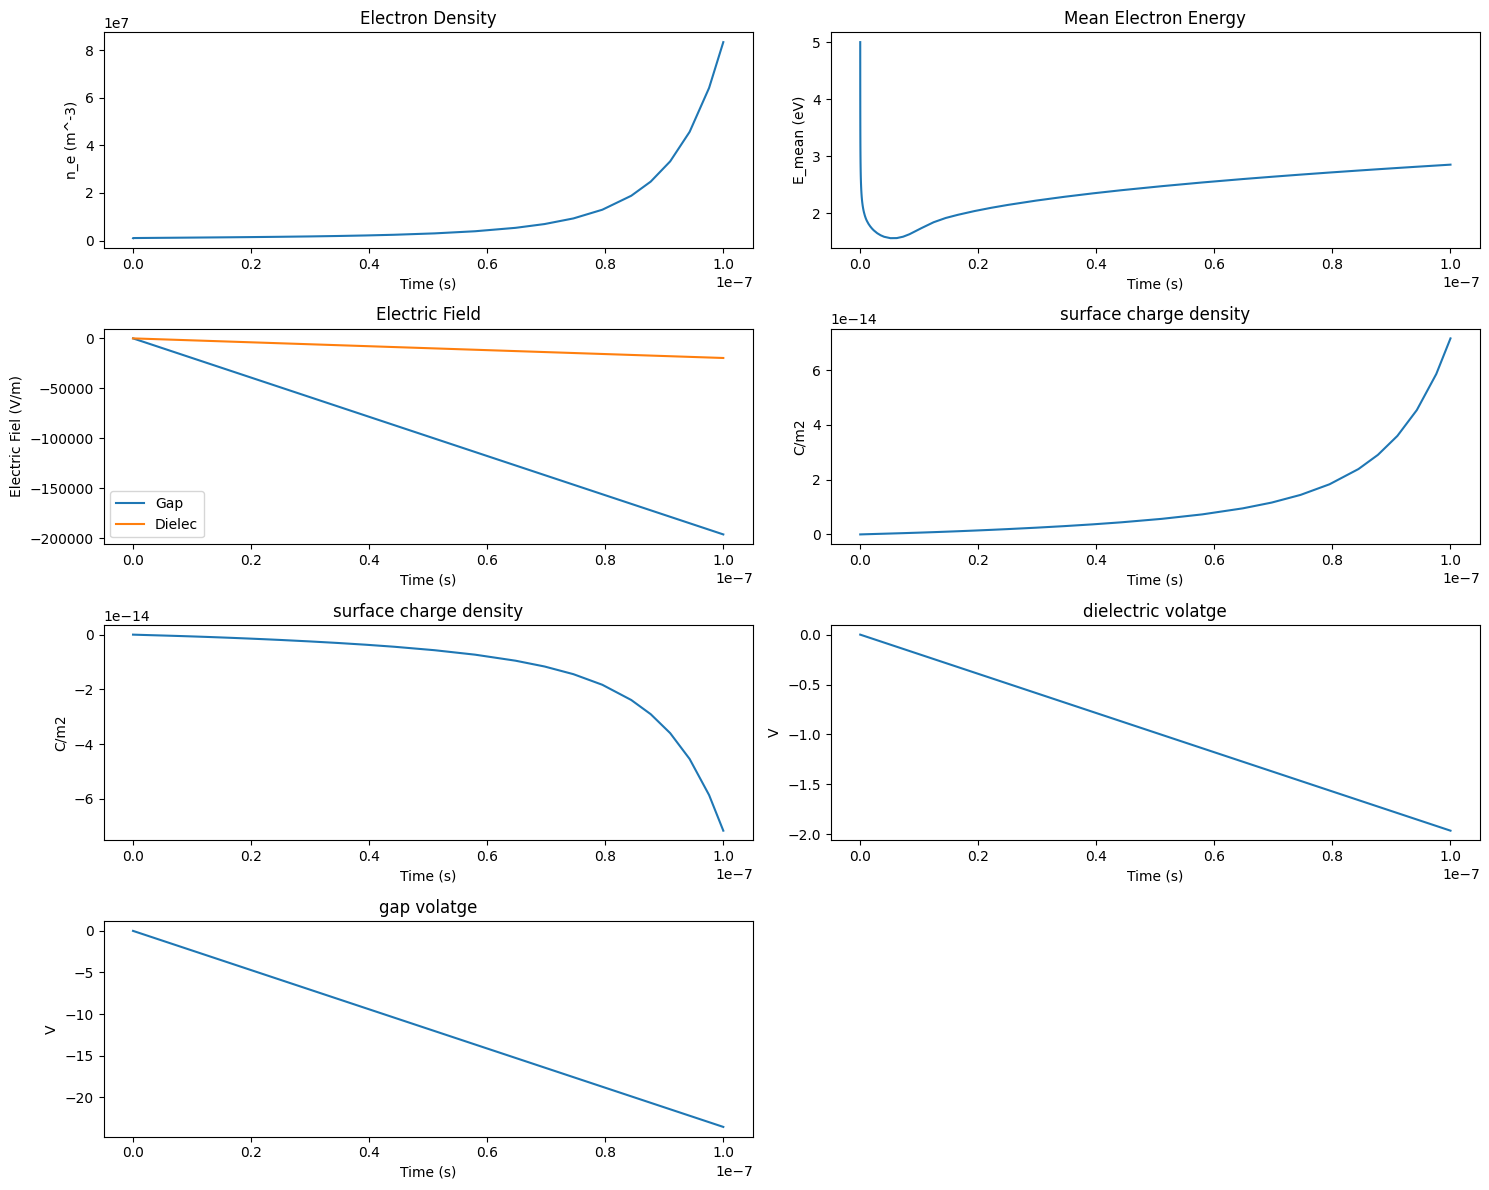

In [132]:
# 결과 플로팅
plt.figure(figsize=(15, 12))

plt.subplot(421)
plt.plot(sol.t, sol.y[0])
plt.title('Electron Density')
plt.xlabel('Time (s)')
plt.ylabel('n_e (m^-3)')

plt.subplot(422)
plt.plot(sol.t, sol.y[4]/sol.y[0])
plt.title('Mean Electron Energy')
plt.xlabel('Time (s)')
plt.ylabel('E_mean (eV)')

plt.subplot(423)
V_applied = -V0 * np.sin(w0 * sol.t)
A = np.array([[-epsr,1,0],[0,-1,epsr],[1,1,1]])
B = np.array([sol.y[5]*ddiel/eps0,sol.y[6]*ddiel/eps0, V_applied])
V_d1, V_gap, V_d2 = np.linalg.solve(A, B)

E_d1 = V_d1 / ddiel
E_gap = V_gap / dgap
E_d2 = V_d2 / ddiel
plt.plot(sol.t, E_gap, label='Gap')
plt.plot(sol.t, E_d1, label='Dielec')
plt.title('Electric Field')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Electric Fiel (V/m)')

plt.subplot(424)
plt.plot(sol.t, sol.y[5])
plt.title('surface charge density')
plt.xlabel('Time (s)')
plt.ylabel('C/m2')


plt.subplot(425)
plt.plot(sol.t, sol.y[6])
plt.title('surface charge density')
plt.xlabel('Time (s)')
plt.ylabel('C/m2')

plt.subplot(426)
plt.plot(sol.t, V_d1)
plt.title('dielectric volatge')
plt.xlabel('Time (s)')
plt.ylabel('V')

plt.subplot(427)
plt.plot(sol.t, V_applied)
plt.title('gap volatge')
plt.xlabel('Time (s)')
plt.ylabel('V')

plt.tight_layout()
plt.show()